C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

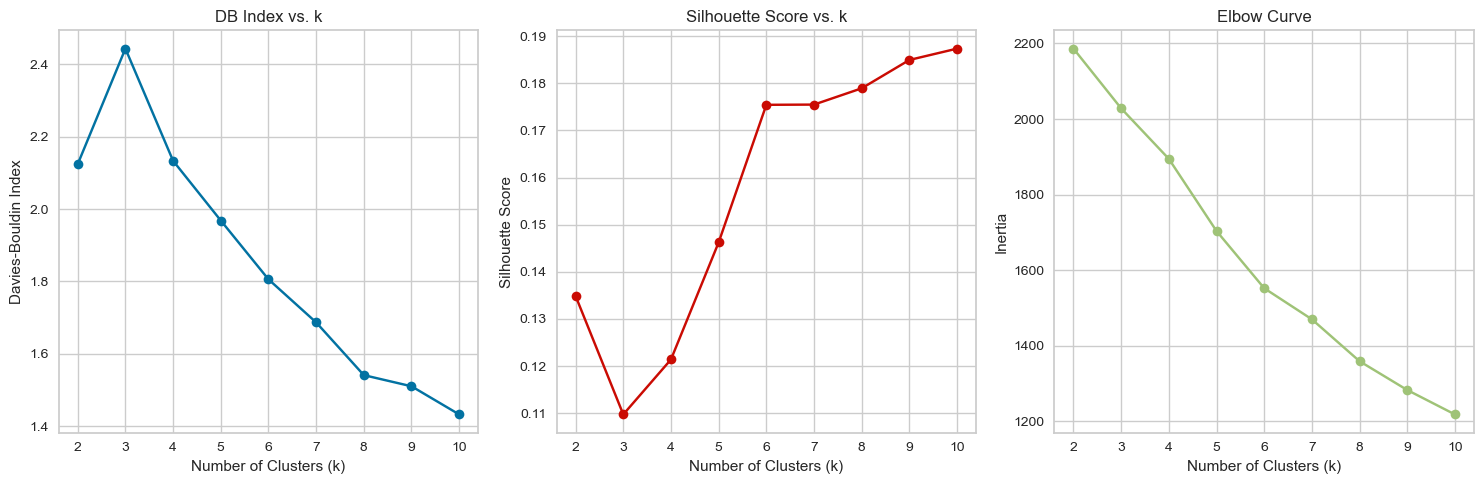


Optimal number of clusters (k): 10
Best Davies-Bouldin Index: 1.4324
Corresponding Silhouette Score: 0.1874

Cluster Summary:
         Size  Avg_Transactions  Avg_Spend  DB_Index  Silhouette_Score
Cluster                                                               
0          21              7.00    5685.94      1.43              0.19
1          24              4.54    2746.06      1.43              0.19
2          20              6.85    5665.97      1.43              0.19
3          29              3.93    2230.62      1.43              0.19
4          10              2.60    2233.43      1.43              0.19
5          25              6.64    4692.54      1.43              0.19
6          12              3.00    1479.52      1.43              0.19
7          14              4.21    3127.44      1.43              0.19
8          12              2.58    1583.72      1.43              0.19
9          32              5.47    3327.73      1.43              0.19


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [13]:
# using kmean cluster
#Note: Here if dataste are more then uncomment the PCA 
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load and prepare data
# Using the same customer profiles from lookalike model
customers_df = pd.read_csv('Customers.csv')
products_df = pd.read_csv('Products.csv')
transactions_df = pd.read_csv('Transactions.csv')

def create_clustering_features():
    # Transaction metrics
    transaction_metrics = transactions_df.groupby('CustomerID').agg({
        'TransactionID': 'count',
        'TotalValue': ['sum', 'mean'],
        'Quantity': ['sum', 'mean']
    })
    transaction_metrics.columns = ['_'.join(col).strip() for col in transaction_metrics.columns.values]
    
    # Category preferences
    category_data = pd.merge(transactions_df, products_df[['ProductID', 'Category']], on='ProductID')
    category_prefs = pd.crosstab(category_data['CustomerID'], category_data['Category'], normalize='index')
    
    # Region encoding
    region_dummies = pd.get_dummies(customers_df.set_index('CustomerID')['Region'], prefix='Region')
    
    # Combine features
    features = pd.merge(transaction_metrics, category_prefs, left_index=True, right_index=True, how='left')
    features = pd.merge(features, region_dummies, left_index=True, right_index=True, how='left')
    
    return features

# 2. Create and scale features
features = create_clustering_features()
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# 3. Find optimal number of clusters using DB Index
k_range = range(2, 11)
db_scores = []
silhouette_scores = []
inertias = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_features)
    
    db_scores.append(davies_bouldin_score(scaled_features, labels))
    silhouette_scores.append(silhouette_score(scaled_features, labels))
    inertias.append(kmeans.inertia_)

# Plot evaluation metrics
plt.figure(figsize=(15, 5))

# DB Index
plt.subplot(1, 3, 1)
plt.plot(k_range, db_scores, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.title('DB Index vs. k')

# Silhouette Score
plt.subplot(1, 3, 2)
plt.plot(k_range, silhouette_scores, 'ro-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. k')

# Elbow Curve
plt.subplot(1, 3, 3)
plt.plot(k_range, inertias, 'go-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Curve')

plt.tight_layout()
plt.show()

# 4. Optimal k based on DB Index
optimal_k = k_range[np.argmin(db_scores)]
print(f"\nOptimal number of clusters (k): {optimal_k}")
print(f"Best Davies-Bouldin Index: {min(db_scores):.4f}")
print(f"Corresponding Silhouette Score: {silhouette_scores[optimal_k-2]:.4f}")

# 5. Final clustering with optimal k
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = final_kmeans.fit_predict(scaled_features)

# 6. Visualize clusters using PCA
# pca = PCA(n_components=2)
# pca_features = pca.fit_transform(scaled_features)

# plt.figure(figsize=(10, 8))
# scatter = plt.scatter(pca_features[:, 0], pca_features[:, 1], 
#                      c=cluster_labels, cmap='viridis')
# plt.xlabel('First Principal Component')
# plt.ylabel('Second Principal Component')
# plt.title(f'Customer Segments (k={optimal_k})')
# plt.colorbar(scatter, label='Cluster')
# plt.show()

# 7. Analyze cluster characteristics
features['Cluster'] = cluster_labels
cluster_profiles = features.groupby('Cluster').mean()

# Save results
clustering_results = pd.DataFrame({
    'CustomerID': features.index,
    'Cluster': cluster_labels
})
clustering_results.to_csv('FirstName_LastName_Clustering.csv', index=False)

# Create PDF report content
cluster_summary = pd.DataFrame({
    'Size': features.groupby('Cluster').size(),
    'Avg_Transactions': features.groupby('Cluster')['TransactionID_count'].mean(),
    'Avg_Spend': features.groupby('Cluster')['TotalValue_sum'].mean(),
    'DB_Index': min(db_scores),
    'Silhouette_Score': silhouette_scores[optimal_k-2]
}).round(2)

print("\nCluster Summary:")
print(cluster_summary)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

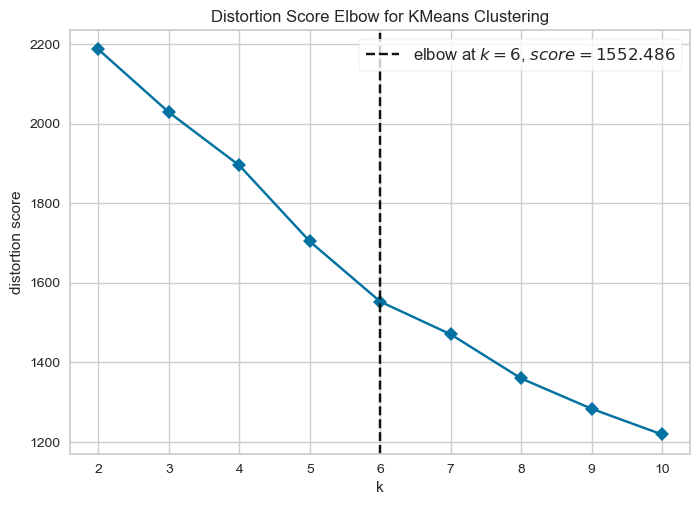

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


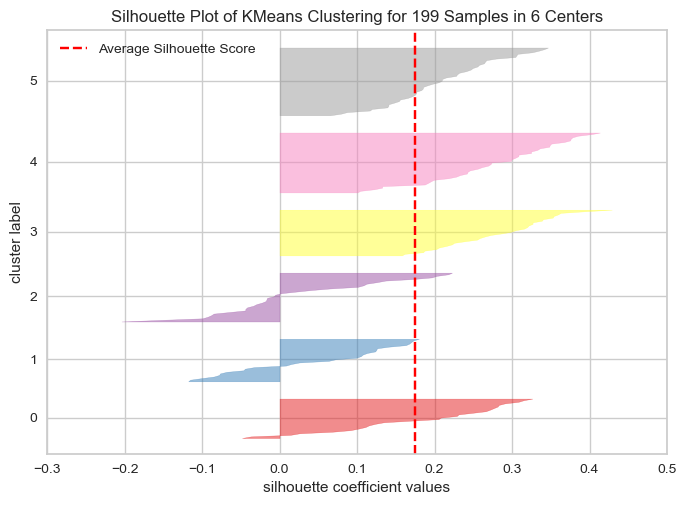


Cluster Summary:
         Size  Avg_Transactions  Avg_Spend  DB_Index  Silhouette_Score
Cluster                                                               
0          26              7.85    5928.37      1.81              0.18
1          28              4.29    2652.22      1.81              0.18
2          32              2.84    1582.18      1.81              0.18
3          30              6.23    5039.59      1.81              0.18
4          39              4.97    3025.01      1.81              0.18
5          44              4.64    3222.79      1.81              0.18


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [14]:
#using Kmean++ cluster
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# 1. Load and prepare data
customers_df = pd.read_csv('Customers.csv')
products_df = pd.read_csv('Products.csv')
transactions_df = pd.read_csv('Transactions.csv')

def create_clustering_features():
    # Transaction metrics
    transaction_metrics = transactions_df.groupby('CustomerID').agg({
        'TransactionID': 'count',
        'TotalValue': ['sum', 'mean'],
        'Quantity': ['sum', 'mean']
    })
    transaction_metrics.columns = ['_'.join(col).strip() for col in transaction_metrics.columns.values]
    
    # Category preferences
    category_data = pd.merge(transactions_df, products_df[['ProductID', 'Category']], on='ProductID')
    category_prefs = pd.crosstab(category_data['CustomerID'], category_data['Category'], normalize='index')
    
    # Region encoding
    region_dummies = pd.get_dummies(customers_df.set_index('CustomerID')['Region'], prefix='Region')
    
    # Combine features
    features = pd.merge(transaction_metrics, category_prefs, left_index=True, right_index=True, how='left')
    features = pd.merge(features, region_dummies, left_index=True, right_index=True, how='left')
    
    return features

# 2. Create and scale features
features = create_clustering_features()
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# 3. Find optimal number of clusters using KMeans++
kmeans_plus = KMeans(random_state=42, init='k-means++')

# Use Elbow Method to find optimal k
elbow_visualizer = KElbowVisualizer(kmeans_plus, k=(2, 11), metric='distortion', timings=False)
elbow_visualizer.fit(scaled_features)
elbow_visualizer.show()

optimal_k = elbow_visualizer.elbow_value_

# Use Silhouette Visualizer to confirm optimal k
silhouette_visualizer = SilhouetteVisualizer(KMeans(n_clusters=optimal_k, init='k-means++', random_state=42))
silhouette_visualizer.fit(scaled_features)
silhouette_visualizer.show()

# 4. Perform final clustering
final_kmeans_plus = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
cluster_labels = final_kmeans_plus.fit_predict(scaled_features)

# 5. Visualize clusters using PCA
# pca = PCA(n_components=2)
# pca_features = pca.fit_transform(scaled_features)

# plt.figure(figsize=(10, 8))
# scatter = plt.scatter(pca_features[:, 0], pca_features[:, 1], 
#                      c=cluster_labels, cmap='viridis')
# plt.xlabel('First Principal Component')
# plt.ylabel('Second Principal Component')
# plt.title(f'Customer Segments (k={optimal_k}, KMeans++)')
# plt.colorbar(scatter, label='Cluster')
# plt.show()

# 6. Analyze cluster characteristics
features['Cluster'] = cluster_labels
cluster_profiles = features.groupby('Cluster').mean()

# Save results
clustering_results = pd.DataFrame({
    'CustomerID': features.index,
    'Cluster': cluster_labels
})
clustering_results.to_csv('FirstName_LastName_Clustering_Plus.csv', index=False)

# Create PDF report content
cluster_summary = pd.DataFrame({
    'Size': features.groupby('Cluster').size(),
    'Avg_Transactions': features.groupby('Cluster')['TransactionID_count'].mean(),
    'Avg_Spend': features.groupby('Cluster')['TotalValue_sum'].mean(),
    'DB_Index': davies_bouldin_score(scaled_features, cluster_labels),
    'Silhouette_Score': silhouette_score(scaled_features, cluster_labels)
}).round(2)

print("\nCluster Summary:")
print(cluster_summary)
